<a href="https://colab.research.google.com/github/KimRass/Programming/blob/master/Data%20Science/Machine%20Learning/Time%20Series/Quandl%20WIKI%20Stock%20Prices%20%26%20TimeGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

In [ ]:
# Data Science/Machine Learning/Time Series/Quandl WIKI Stock Prices & TimeGAN.ipynb
from google.colab import drive
import os
drive.mount("/content/drive")
os.chdir("/content")

import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.models import Sequential, Model
from tqdm import tqdm
from pathlib import Path
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

plt.style.use("dark_background")

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/TS")
raw_data = pd.read_hdf("Datasets/Quandl WIKI Stock Prices:/assets.h5", key="quandl/wiki/prices")

In [ ]:
data = raw_data["adj_close"]
data = data.unstack("ticker")
tickers = ["BA", "CAT", "DIS", "GE", "IBM", "KO"]
data = data[tickers]
data = data.dropna()
# data.asfreq("D")

In [ ]:
n_seq = 6

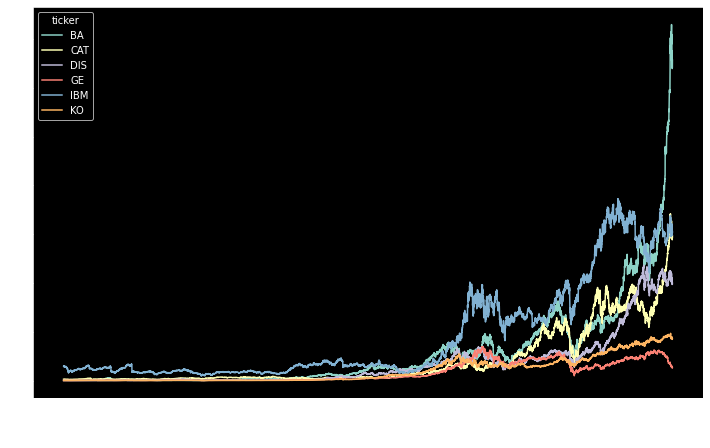

In [ ]:
data.plot.line(figsize=(12, 8));

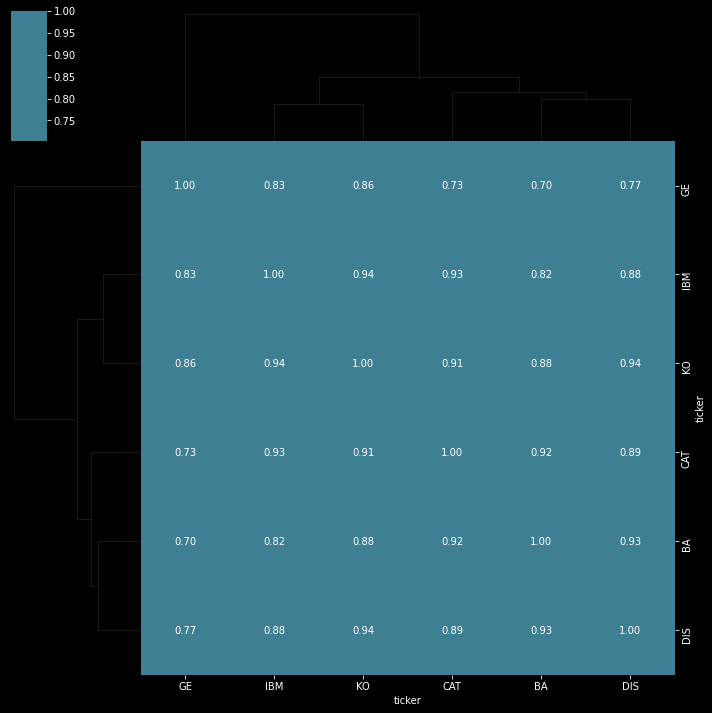

In [ ]:
sb.clustermap(data.corr(), annot=True, fmt=".2f", cmap=sb.diverging_palette(h_neg=20, h_pos=220), center=0);

In [ ]:
# sc = StandardScaler()
sc = MinMaxScaler()
data_norm = sc.fit_transform(data)

def blocked_cv(data, window_size, h, step=1):
    X = list()
    for i in range(0, len(data) - window_size - h + 1, step):
        X.append(data[i:i + window_size])
    return X

window_size = 24
X = blocked_cv(data_norm, window_size, h=0)

In [ ]:
batch_size = 128
real_series = (tf.data.Dataset.from_tensor_slices(X).shuffle(buffer_size=len(X)).batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [ ]:
# Fake time series
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [ ]:
random_series = iter(tf.data.Dataset.from_generator(make_random_data, output_types=tf.float32).batch(batch_size).repeat())

# Modeling

In [ ]:
hidden_dim = 512 # 512
num_layers = 8 # 8

In [ ]:
# 학습 중간 중간 과정을 저장하는 log writer
writer = tf.summary.create_file_writer(log_dir.as_posix())

In [ ]:
X = Input(shape=(seq_len, n_seq), name="RealData")
Z = Input(shape=(seq_len, n_seq), name="RandomData")

In [ ]:
# RNN layer를 만드는 추상화 함수.
               # 3         24
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units, return_sequences=True, name=f"GRU_{i + 1}") for i in range(n_layers)] + [Dense(units=output_units, activation="sigmoid", name="OUT")], name=name)

In [ ]:
# embedder (encoder) / recovery (decoder)
# Autoencoder + GAN
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name="Embedder")
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name="Recovery")

In [ ]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name="Generator")
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name="Discriminator")
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name="Supervisor")

In [ ]:
# epochs
train_steps = 100000
gamma = 1


mse = MeanSquaredError()
bce = BinaryCrossentropy()

H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X, outputs=X_tilde, name="Autoencoder")

In [ ]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 6)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 512)           4213248   
                                                                 
 Recovery (Sequential)       (None, 24, 6)             4730886   
                                                                 
Total params: 8,944,134
Trainable params: 8,944,134
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plot_model(autoencoder, to_file=(results_path / "autoencoder.png").as_posix(), show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
autoencoder_optimizer = Adam()

In [ ]:
@tf.function()
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar("Loss Autoencoder Init", step_e_loss_t0, step=step)

  0%|▏                                                                         | 270/100000 [16:58<88:47:30,  3.21s/it]

In [ ]:
autoencoder.save(log_dir / "autoencoder")

In [ ]:
supervisor_optimizer = Adam()

In [ ]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar("Loss Generator Supervised Init", step_g_loss_s, step=step)

In [ ]:
supervisor.save(log_dir/"supervisor")

In [ ]:
E_hat = generator(Z) # generator + supervisor = generator
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z, outputs=Y_fake, name="AdversarialNetSupervised")

In [ ]:
adversarial_supervised.summary()

In [ ]:
plot_model(adversarial_supervised, show_shapes=True)

In [ ]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z, outputs=Y_fake_e, name="AdversarialNet")

In [ ]:
adversarial_emb.summary()

In [ ]:
plot_model(adversarial_emb, show_shapes=True)

In [ ]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name="SyntheticData")

In [ ]:
synthetic_data.summary()

In [ ]:
plot_model(synthetic_data, show_shapes=True)

In [ ]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

In [ ]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name="DiscriminatorReal")

In [ ]:
discriminator_model.summary()

In [ ]:
plot_model(discriminator_model, show_shapes=True)

In [ ]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

In [ ]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

In [ ]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

In [ ]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f"{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | "
              f"g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}")

    with writer.as_default():
        tf.summary.scalar("G Loss S", step_g_loss_s, step=step)
        tf.summary.scalar("G Loss U", step_g_loss_u, step=step)
        tf.summary.scalar("G Loss V", step_g_loss_v, step=step)
        tf.summary.scalar("E Loss T0", step_e_loss_t0, step=step)
        tf.summary.scalar("D Loss", step_d_loss, step=step)

In [ ]:
synthetic_data.save(log_dir / "synthetic_data")

In [ ]:
generated_data = []
for i in range(int(n_windows/batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [ ]:
len(generated_data)

In [ ]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

In [ ]:
np.save(log_dir/"generated_data.npy", generated_data)

In [ ]:
generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, seq_len, n_seq))
generated_data.shape

In [ ]:
with pd.HdataStore(hdata_store) as store:
    store.put("data/synthetic", pd.DataFrame(generated_data.reshape(-1, n_seq), columns=tickers))

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(data) - seq_len)
real = data.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({"Real": real.iloc[:, j].values,
                   "Synthetic": synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y="Synthetic", style=["-", "--"],
           lw=1))
sb.despine()
fig.tight_layout()